<a href="https://colab.research.google.com/github/linhobs/100-days-of-code/blob/master/prompt_crafter_langchain_multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-modal RAG with LangChain

##get rid of dependency conflicts with open telemetry
only for colab **environment**

In [1]:
from google.colab import userdata


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## SetUp

Install the dependencies you need to run the notebook.

In [3]:
# for linux
!apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# !brew install poppler tesseract libmagic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  libmagic-dev poppler-utils
0 upgraded, 2 newly installed, 0 to remove and 38 not upgraded.
Need to get 291 kB of archives.
After this operation, 1,086 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libmagic-dev amd64 1:5.41-3ubuntu0.1 [105 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.11 [186 kB]
Fetched 291 kB in 1s (490 kB/s)
Selecting previously unselected package libmagic-dev:amd64.
(Reading database ... 126455 files and directories currently installed.)
Preparing to unpack .../libmagic-dev_1%3a5.41-3ubuntu0.1_amd64.deb ...
Unpacking libmagic-dev:amd64 (1:5.41-3ubuntu0.1) ...
Selecting previously unselected package poppler-utils.
Preparing to unpack .../poppler-

In [4]:
! pip install --upgrade-strategy only-if-needed -Uq "unstructured[all-docs]" pillow==11.3.0 lxml pillow==11.3.0
! pip  install --upgrade-strategy only-if-needed -Uq chromadb tiktoken
!pip  install --upgrade-strategy only-if-needed -Uq langchain langchain-community langchain-openai langchain-groq langchain_core
! pip install  --upgrade-strategy only-if-needed -Uq python_dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 54.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.1/529.1 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 4.2 MB/s eta 0:00:00
  

In [5]:
! pip install  langchain-classic

In [6]:
import os
# keys for the services we will use
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["GROQ_API_KEY"] =userdata.get("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")

In [7]:
KNOWLEDGE_DIR = "/content/drive/MyDrive/prompt_tune/knowledge"
VECTORE_STORE_DIR = "/content/drive/MyDrive/prompt_tune/vector_store"
# create path if not exist
if not os.path.exists(VECTORE_STORE_DIR):
    os.makedirs(VECTORE_STORE_DIR, exist_ok=True)


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [8]:
from unstructured.partition.pdf import partition_pdf
import os, json, datetime, traceback
from typing import List


# Common chunking knobs
CHUNKING_KW = dict(
    chunking_strategy="by_title",   # or "basic"
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
)

from unstructured.partition.pdf import partition_pdf
from unstructured.partition.docx import partition_docx
try:
    # DOC legacy support if for .doc files
    from unstructured.partition.doc import partition_doc
    HAS_DOC = True
except Exception:
    HAS_DOC = False

# --- 4) Collect all candidate files in the folder (non-recursive by default) ---
VALID_EXTS = {".pdf", ".docx", ".doc"}
all_files: List[str] = []
for name in sorted(os.listdir(KNOWLEDGE_DIR)):
    ext = os.path.splitext(name)[1].lower()
    if ext in VALID_EXTS:
        all_files.append(os.path.join(KNOWLEDGE_DIR, name))

print(f"Found {len(all_files)} files:", *[os.path.basename(p) for p in all_files], sep="\n- ")

# --- 5) Helper to partition one file with correct backend/kwargs ---
def partition_one(path: str):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".pdf":
        # PDF: use hi_res + table inference (as in your original snippet)
        return partition_pdf(
            filename=path,
            infer_table_structure=True,
            strategy="hi_res",
            extract_image_block_types=["Image"],     # Add 'Table' to also extract table render images
            extract_image_block_to_payload=True,
            **CHUNKING_KW,
        )
    elif ext == ".docx":
        return partition_docx(
            filename=path,
            **CHUNKING_KW,
        )
    elif ext == ".doc" and HAS_DOC:
        return partition_doc(
            filename=path,
            **CHUNKING_KW,
        )
    else:
        raise ValueError(f"Unsupported extension or missing parser for: {path}")



Found 8 files:
- 2101.04248v2.pdf
- 32858-Article Text-36926-1-2-20250410 (4).pdf
- 9000929 AJ 5X Decathlon System Training (1) (3).pdf
- Automatic_Reconstruction_of_3D_Models_from_2D_Draw.pdf
- Guidelines for Reconstructing 3D CAD Models from 2D Legacy Sketches.docx
- Reconstruction of gusset plate revision.docx
- Second Ground Truth Reference for Pipeline.docx
- __Guidelines for Reconstructing 3D CAD Models from 2D Engineering Drawings__.docx


In [9]:
chunks = []
for fp in all_files:
    chunk = partition_one(fp)
    chunks.extend(chunk)


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [10]:
# We get 2 types of elements from the partition_pdf function. Only Composite elements for now because we don't have tables in any of our docs
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [11]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [12]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
len(chunk_images)
# chunk_images[0].to_dict()

0

### Separate extracted elements into tables, text, and images

In [13]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [14]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

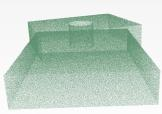

In [17]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[12])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [18]:
%pip install -Uq langchain-groq

In [19]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [20]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [21]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})


In [26]:
# write text summaries to .txt file for easy retrieval
with open(KNOWLEDGE_DIR + "/text_summaries_.txt", "w") as f:
    for summary in text_summaries:
        f.write(summary + "\n")

In [23]:
text_summaries

['The study utilises OpenCV to convert 2D engineering drawings into 3D CAD models, leveraging photos rather than scans or electronic documentation. The method reconstructs 3D solid models in SCAD format and generates 3D point cloud data, effectively addressing the conversion of historical mechanical, aerospace, and civil engineering designs.',
 "This work uses OpenCV to convert 2D images into 3D SCAD solids by detecting contours, creating a bounding box, and mapping points to a 3D CAD model. The process involves contour detection, point location, and feature extraction, utilizing functions such as cv2.moments() to calculate moments and determine the centroid of the image. A signed distance function is used to determine a point's location relative to the contour.",
 'The conversion to a 3D model involves recognizing 2D shapes using the Ramer-Douglas-Peucker algorithm, converting them into SCAD format, and performing Boolean operations. The algorithmic implementation involves five stages

In [22]:

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [24]:
table_summaries

[]

In [ ]:
!pip install -Uq langchain_openai langchain

### Image summaries (ignore for now)

We will use gpt-4o-mini to produce the image summaries.

In [ ]:
len(images)

455

In [ ]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail.  Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images,{"max_concurrency": 3})

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IaOJQbU9KNIjlIFuFSszeKZF on tokens per min (TPM): Limit 200000, Used 200000, Requested 786. Please try again in 235ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [ ]:
image_summaries

NameError: name 'image_summaries' is not defined

In [ ]:
print(image_summaries[1])

The image depicts two main concepts from the transformer architecture: **Scaled Dot-Product Attention** and **Multi-Head Attention**.

### Scaled Dot-Product Attention (Left Side)
1. **Structure**: 
   - The flow starts with three inputs represented as **Q** (Query), **K** (Key), and **V** (Value).
   - The first operation is a **MatMul** (matrix multiplication) between Q and K, producing a score.
   - This score is then passed to a **Scale** component, which adjusts the magnitude of the scores.
   - An optional **Mask** is applied next to prevent certain positions from being attended to, often used in tasks like language modeling.
   - The scores are then passed through a **SoftMax** layer to convert them into probabilities.
   - Finally, another **MatMul** operation takes the output from SoftMax and multiplies it by V to produce the final attention output.

### Multi-Head Attention (Right Side)
1. **Structure**:
   - This section builds upon the scaled dot-product attention.
   - It 

In [ ]:
%pip install --upgrade --quiet langchain

## Load data and summaries to vectorstore

### Create the vectorstore

In [33]:
import uuid
from langchain_classic.vectorstores import Chroma
from langchain_classic.storage import InMemoryStore
from langchain_classic.schema.document import Document
from langchain_classic.embeddings import OpenAIEmbeddings
from langchain_classic.retrievers.multi_vector import MultiVectorRetriever
from pathlib import Path

# The vectorstore to use to index the child chunks
persist_directory = VECTORE_STORE_DIR + "/multimodal_prompt_rag_db"
def chroma_db_exists(persist_dir: Path) -> bool:
    """Detect a previously persisted Chroma DB (handles both legacy and newer layouts)."""
    expected_any = [
        "chroma.sqlite3",                 # legacy single-file
        "chroma-collections.parquet",     # parquet layout
        "chroma-embeddings.parquet",
        "index",                          # v0.5+ index folder
    ]
    if not persist_dir.is_dir():
        return False
    return any((persist_dir / name).exists() for name in expected_any)

if chroma_db_exists(Path(persist_directory)):
  print(f"Reusing existing vectorstore at {persist_directory}")
  vectorstore = Chroma(
      collection_name="multi_modal_rag",
      embedding_function=OpenAIEmbeddings(),
      persist_directory = persist_directory)
else:
  print(f"Creating new vectorstore at {persist_directory}")
  vectorstore = Chroma(
      collection_name="multi_modal_rag",
      embedding_function=OpenAIEmbeddings(),
      persist_directory = persist_directory)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

Reusing existing vectorstore at /content/drive/MyDrive/prompt_tune/vector_store/multimodal_prompt_rag_db


### Load the summaries and link the to the original data

In [35]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
if len(table_summaries) > 0:
  table_ids = [str(uuid.uuid4()) for _ in tables]
  summary_tables = [
      Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
  ]
  retriever.vectorstore.add_documents(summary_tables)
  retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
# img_ids = [str(uuid.uuid4()) for _ in images]
# summary_img = [
#     Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
# ]
# retriever.vectorstore.add_documents(summary_img)
# retriever.docstore.mset(list(zip(img_ids, images)))


## Intent Parsing



In [46]:
# question for testing retrieval
question = "How to conduct leak test on 100um nozzle UA atomizer?"

In [47]:
# use an LLM to extract intent and vars from user entered goal
# intent can be used in selecting few shot example instead of query construction
from langchain_openai import ChatOpenAI

template = """You are an AI language model assistant. Your task is to extract manufacturing intent from a given user goal. Return only valid JSON\n
Rules:
- Infer task_type (diagnosis/guidance/compliance/optimization).
- Extract key entities, parameters, anomalies.
- If unknown, set null.
- Extract any additional inputs into 'inputs' (JSON map).

goal: {question}
"""
prompt_intent = ChatPromptTemplate.from_template(template)
parse_intent = (prompt_intent | ChatOpenAI(model = "gpt-4-turbo-preview",temperature=0) | StrOutputParser())
# parsed_intent = parse_intent.invoke({"question":question})


In [48]:
# print(parsed_intent)

```json
{
  "task_type": "guidance",
  "key_entities": [
    "leak test",
    "100um nozzle",
    "UA atomizer"
  ],
  "parameters": null,
  "anomalies": null,
  "inputs": {
    "object_under_test": "UA atomizer",
    "specific_part": "100um nozzle"
  }
}
```


## Query construction from parsed intent
- Experiment with multiquery, RRF, HYDE later in ablation studies

### MultiQuery

In [55]:
# use an LLM to generate query from parsed intent and user goal
from langchain_core.runnables import RunnablePassthrough, RunnableLambda


template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
use the provided parsed intent together with the user question.The parsed intent contains the user's intent, task type and entities about the task
\nTerminology note: 'Ultrasonic atomizer' is abbreviated as UA and 'Pneumatic atomizer' is abbreviated as PA. Leak test is also sometimes represented as leak  check. match these forms.
\n
Provide these alternative questions separated by newlines. Original question: {question} \n parsed intent : {intent}"""

prompt_perspectives = ChatPromptTemplate.from_template(template)
# generate query
generate_queries_multiquery = (
    {"question":RunnablePassthrough(), "intent": parse_intent}
    |prompt_perspectives
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

#


def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists
    flattened_docs = [doc for sublist in documents for doc in sublist]
    # Use a set to store unique documents based on content and metadata
    # unique_docs = list(set(flattened_docs))

    return [doc for doc in flattened_docs]

### RAG Fusion/ RRF

In [58]:
# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
use the provided parsed intent together with the user question.The parsed intent contains the user's intent, task type and entities about the task \n
parse intent {intent}\n
Terminology note: 'Ultrasonic atomizer' is abbreviated as UA and 'Pneumatic atomizer' is abbreviated as PA. Leak test is also sometimes represented as leak  check. match these forms.
\n Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)
generate_queries_rrf = (
    {"question":RunnablePassthrough(), "intent": parse_intent}
    |prompt_rag_fusion
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents
        and an optional parameter k used in the RRF formula """

    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            doc_str = doc.text
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (doc, score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results



### HYDE

In [59]:
# HyDE document generation
template = """Please write a guideline passage to answer the question
\n Terminology note: 'Ultrasonic atomizer' is abbreviated as UA and 'Pneumatic atomizer' is abbreviated as PA. Leak test is also sometimes represented as leak  check. match these forms.
\n
use the provided parsed intent together with the user question.The parsed intent contains the user's intent, task type and entities about the task
Question: {question}
Parsed intent: {intent}
\n
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)
generate_docs_for_retrieval = (
    {"question":RunnablePassthrough(), "intent": parse_intent}
    |prompt_hyde
    | ChatOpenAI(temperature=0) | StrOutputParser()
)

## Retrieval
Test retrieval

In [60]:
# Retrieve (Vanilla retriever)
docs = retriever.invoke(
    "How to conduct leak test on ultrasonic atomizer?"
)
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)
# not the best retrieval
# Let's explore better retrieval techniques/ or Agent and see

8.4 Reassembly

Reassemble the pneumatic atomizer in reverse order detailed in 8.1 Atomizer Assembly.

9000929 AJ 5X Decathlon System Training

Page 99

OPTOMEC ENE EEN

Fine Feature Printing with Pneumatic Atomizer

Chapter 9 Fine Feature Printing with Pneumatic Atomizer

9.1 Setup for printing

9.1.1 Leak Check

The system is pressurized using the atomizer and VI sheath mass flow controllers in KEWA. The outlined procedure is used to identify the presence of gas leaks in the pneumatic cassette, Figure 97. Leaks typically occur around external O-rings or tubing connections associated with the introduction or evacuation of gas from the system. In addition to the manual leak check procedure outlined, an automated process recipe titled ‘PA_Leak Check.ini’ can be provided by Optomec engineering.

VI Exhaust Mist exit tube plug

VI Exhaust

Mist exit tube plug

Mist exit

tube plug

Figure 97. Cassette leak check setup

9000929 AJ 5X Decathlon System Training

Page 100

OPTOM Anterior tae 

In [61]:
# multi query retrieval
retrieval_chain_multiquery = generate_queries_multiquery | retriever.map() | get_unique_union
docs = retrieval_chain_multiquery.invoke(question)
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

8.4 Reassembly

Reassemble the pneumatic atomizer in reverse order detailed in 8.1 Atomizer Assembly.

9000929 AJ 5X Decathlon System Training

Page 99

OPTOMEC ENE EEN

Fine Feature Printing with Pneumatic Atomizer

Chapter 9 Fine Feature Printing with Pneumatic Atomizer

9.1 Setup for printing

9.1.1 Leak Check

The system is pressurized using the atomizer and VI sheath mass flow controllers in KEWA. The outlined procedure is used to identify the presence of gas leaks in the pneumatic cassette, Figure 97. Leaks typically occur around external O-rings or tubing connections associated with the introduction or evacuation of gas from the system. In addition to the manual leak check procedure outlined, an automated process recipe titled ‘PA_Leak Check.ini’ can be provided by Optomec engineering.

VI Exhaust Mist exit tube plug

VI Exhaust

Mist exit tube plug

Mist exit

tube plug

Figure 97. Cassette leak check setup

9000929 AJ 5X Decathlon System Training

Page 100

OPTOM Anterior tae 

In [67]:
# rrf retrieval
retrieval_chain_rag_fusion = generate_queries_rrf | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

('8.4 Reassembly\n\nReassemble the pneumatic atomizer in reverse order detailed in 8.1 Atomizer Assembly.\n\n9000929 AJ 5X Decathlon System Training\n\nPage 99\n\nOPTOMEC ENE EEN\n\nFine Feature Printing with Pneumatic Atomizer\n\nChapter 9 Fine Feature Printing with Pneumatic Atomizer\n\n9.1 Setup for printing\n\n9.1.1 Leak Check\n\nThe system is pressurized using the atomizer and VI sheath mass flow controllers in KEWA. The outlined procedure is used to identify the presence of gas leaks in the pneumatic cassette, Figure 97. Leaks typically occur around external O-rings or tubing connections associated with the introduction or evacuation of gas from the system. In addition to the manual leak check procedure outlined, an automated process recipe titled ‘PA_Leak Check.ini’ can be provided by Optomec engineering.\n\nVI Exhaust Mist exit tube plug\n\nVI Exhaust\n\nMist exit tube plug\n\nMist exit\n\ntube plug\n\nFigure 97. Cassette leak check setup\n\n9000929 AJ 5X Decathlon System Train

In [62]:
# hyde retrieval
retrieval_chain_hyde = generate_docs_for_retrieval | retriever
retrieved_docs = retrieval_chain_hyde.invoke({"question":question})
for doc in retrieved_docs:
    print(str(doc) + "\n\n" + "-" * 80)

8.4 Reassembly

Reassemble the pneumatic atomizer in reverse order detailed in 8.1 Atomizer Assembly.

9000929 AJ 5X Decathlon System Training

Page 99

OPTOMEC ENE EEN

Fine Feature Printing with Pneumatic Atomizer

Chapter 9 Fine Feature Printing with Pneumatic Atomizer

9.1 Setup for printing

9.1.1 Leak Check

The system is pressurized using the atomizer and VI sheath mass flow controllers in KEWA. The outlined procedure is used to identify the presence of gas leaks in the pneumatic cassette, Figure 97. Leaks typically occur around external O-rings or tubing connections associated with the introduction or evacuation of gas from the system. In addition to the manual leak check procedure outlined, an automated process recipe titled ‘PA_Leak Check.ini’ can be provided by Optomec engineering.

VI Exhaust Mist exit tube plug

VI Exhaust

Mist exit tube plug

Mist exit

tube plug

Figure 97. Cassette leak check setup

9000929 AJ 5X Decathlon System Training

Page 100

OPTOM Anterior tae 

### Context filtering / Retrieval summaries

- Extract keywords, summaries, important points from the context (Maybe bullets...): check standard practice

In [ ]:
# use the 3 different retrievers I have as base retrievers and see how it works. If it works we can use that
# else we might have to use an LLM

# don't know how we can use a retrieval chain plus this retriever

## Few Shot Templates
Few shot examples: 2-3 (2 for machine operations and 1 for CAD reconstruction)

## RAG pipeline

Use Retrieved context plus CRAFT template to construct a RAG chain

- We will play around with LangGraph, Memory, etc later
- TODO: add parsed intent

In [69]:
 craft_template = """
    You are a Prompt Engineer. Given a GOAL and an AUTHORITATIVE CONTEXT,
    produce a WELL-DEFINED PROMPT for a separate Executor LLM using CRAFT:
    C — Constraints (safety, specs, compliance, length limits)\n"
    R — Role (+ resources/tools)
    A — Audience\n
    F — Format (explicit schema/markdown) + required Inputs/Outputs
    T — Tone/Style (concise, checklist, JSON).
    Also include an 'Authoritative Context' section (only facts from CONTEXT) and 'Evaluation criteria'. "
    Return ONLY the WELL-DEFINED PROMPT; no extra commentary.
    Always start with the role of the AI (e.g you are an expert in aerosol jet operations)
    Generate based only on the following context, which can include text, tables, and the below image.
    Ensure the language is clear, directive, and optimized for a large language model to interpret and execute the task effectively. If few-shot examples are included, format them as explicit guidance (e.g., "Here are examples of how to perform the task:") and ensure consistency with the rest of the prompt.
    Ensure to add the specific task the LLM is to perform (e.g your task is to provide guidelines for conducting a leak test)
    Context: {context_text}
    Few shot examples: \n
    {few_shot_examples} \n
    Goal: {user_question}

    """

  # add parsed intent and let's see

In [78]:
craft_template = """
You are a Prompt Engineer. Your task is to generate a WELL-DEFINED PROMPT for an Executor LLM using the CRAFT framework,
based on a given GOAL, AUTHORITATIVE CONTEXT, and provided FEW-SHOT EXAMPLES of other prompts previously crafted using the same methodology to guide your reasoning
Use Chain-of-Thought reasoning before generating the final prompt:

- Think step-by-step through what the GOAL requires

- Analyze relevant content from CONTEXT

- Extract structure and style patterns from the few-shot examples

- Explicitly define the CRAFT elements before assembling the final prompt

CRAFT Framework (Use during reasoning and in the final output)
C – Constraints: Clearly define any limits (e.g., safety, compliance, word count, domain boundaries).

R – Role: Specify the role the Executor LLM must assume, and any tools or resources it should use.

A – Audience: Define who the output is for (e.g., technician, researcher, policymaker).

F – Format: Explicitly define the structure (e.g., JSON, table, markdown checklist) and required inputs/outputs.

T – Tone/Style: Describe the tone (e.g., formal, concise, instructional, clinical).

Task:

Using the provided Context, generate a directive, unambiguous, and executable prompt optimized for large language model interpretation. The output must begin with the role of the Executor LLM (e.g., "You are an expert in aerosol jet operations"), followed by a precise task statement (e.g., "Your task is to provide guidelines for conducting a leak test"). If few-shot examples are included, format them clearly under a heading and ensure consistency with the specified format and style.

Include the following mandatory sections in the output prompt:

Authoritative Context: Include only essential, factual details from the provided context.

Evaluation Criteria: Define how the Executor LLM’s output will be assessed (e.g., completeness, technical accuracy, alignment with constraints).
Inputs You Will Receive:

- context_text: Background content (text, tables, images)

- user_question: The specific GOAL or objective

- few_shot_prompts: Previously constructed prompts using CRAFT; use these for style, structure, and clarity alignment

context_text: {context_text}
Few shot examples: \n
  {few_shot_examples} \n
user_question: {user_question}

Return ONLY the WELL-DEFINED PROMPT; no extra commentary.
"""

In [79]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = craft_template.format(
        context_text=context_text, few_shot_examples = None, user_question=user_question
    )
    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )






### Vanilla retriever

In [80]:
# experiment with different retrievers
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)
response = chain.invoke(
    "how to reconstruct 3D CAD model from 2D legacy drawing"
)

print(response)

**You are an expert in CAD modeling and AI-assisted design tools. Your task is to provide a comprehensive guideline for reconstructing a 3D CAD model from a 2D legacy drawing. This guideline should include a step-by-step process detailing the interpretation of 2D features, such as holes, slots, chamfers, and their dimensions, utilizing various CAD scripting tools like OpenSCAD, CadQuery, and FreeCAD Python. The guidance should ensure the resulting 3D model is parametric and watertight, adhering to engineering standards.**

**Authoritative Context:** Converting legacy 2D engineering sketches into 3D parametric CAD models is complex, requiring knowledge of projection methods, datums, and feature extraction from multiple views. A reliable process includes understanding projections, gathering dimensions, and constructing 3D geometries based on drawing fidelity.

**Evaluation Criteria:** The output will be assessed on completeness (covering all key features and processes), technical accurac

### Other retrievers

In [81]:
question = "convert 2D legacy sketch to watertight 3D CAD model"

In [82]:
# run rag on the various retrievers using a for loop
retrievers = [
    retrieval_chain_multiquery,
    retrieval_chain_rag_fusion,
    retrieval_chain_hyde,
]
for retriever_ in retrievers:
  # chain with retriever
  chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)
  response = chain.invoke(
      question
  )
  print("*" * 80, "\n")
  print(response)
  print("*" * 80, "\n\n\n ")



******************************************************************************** 

You are an expert in converting 2D legacy sketches into 3D parametric CAD models. Your task is to provide a step-by-step guideline to construct a watertight 3D CAD model from given 2D legacy drawings by meticulously extracting dimensions, identifying features, and maintaining fidelity to the original design. Include specific instructions on interpreting orthographic views, understanding projection symbols, extracting outlines and dimensions, and implementing the reconstruction using a CAD scripting tool like OpenSCAD. Ensure to cite drawing references to validate decisions made during reconstruction.

**Authoritative Context:** 
Converting legacy 2D engineering drawings into parametric 3D CAD models involves interpreting multiple orthographic views, identifying features such as holes, chamfers, and cuts, and ensuring the final model is a faithful representation of the original drawings. The model should 

### Chain with sources

In [ ]:
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [ ]:
response = chain_with_sources.invoke(
    "how to perform leak check for UA atomizer?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: To perform a leak check for the UA atomizer, follow these steps:

1. Mount the ink vial assembly onto the slide carrier.
2. Mount the slide carrier onto the UIM (Unit Interface Module).
3. Place a plug fitting onto the exit of the mist tube.
4. Set the UA atomizer flow rate to 100 sccm in the KEWA Process Manager.
5. Once the pressure has reached 3 psi, set the gas flow rate to zero.
6. Monitor the feedback from the pressure transducer over a period of at least 1 minute.

During this process, common sources of leaks include missing O-rings and un-tightened fasteners, so ensure all components are properly secured.


Context:
8.4 Reassembly

Reassemble the pneumatic atomizer in reverse order detailed in 8.1 Atomizer Assembly.

9000929 AJ 5X Decathlon System Training

Page 99

OPTOMEC ENE EEN

Fine Feature Printing with Pneumatic Atomizer

Chapter 9 Fine Feature Printing with Pneumatic Atomizer

9.1 Setup for printing

9.1.1 Leak Check

The system is pressurized using the atomiz

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)